# DEMO de la Navaja Negra

Con este cuaderno tienes un ejemplo de RAG y usar Langchain, este cuaderno esta para romper.. duplicalo, retocalo y juega basicamente para entender como funciona.

**Aqui documentacion oficial:**
https://python.langchain.com/docs/introduction/

**Algo que vas a necesitar:**
https://huggingface.co/

**Por si se te atasca el Python:**
https://github.com/mouredev/Hello-Python

**¿Quieres más?** Aquí hay muchos cursos gratis que aprendes un monton y sobretodo.. cacharrea:
https://www.deeplearning.ai/

**Telegram:** @ladyroot_

## ⚠️ AVISO IMPORTANTE SOBRE EL USO ÉTICO Y RESPONSABLE DE LA HERRAMIENTA ⚠️

Esta herramienta se proporciona únicamente para fines de investigación, desarrollo y uso legítimo. Queda estrictamente prohibido su uso para actividades ilícitas o fines que violen las leyes y regulaciones vigentes. Los usuarios son responsables de asegurarse de que el uso de esta herramienta cumpla con todas las normativas legales.

Al utilizar esta herramienta para procesar conversaciones o datos de terceros, es fundamental seguir estas recomendaciones:

⚠️ Obtener consentimiento explícito de las personas involucradas antes de capturar, almacenar o analizar sus conversaciones o datos personales.

⚠️ Asegurar la confidencialidad y privacidad de los datos, implementando medidas de seguridad adecuadas para prevenir accesos no autorizados.

⚠️ Respetar los derechos de privacidad de las personas, procesando únicamente datos necesarios y eliminando cualquier información no relevante o que ya no sea necesaria.

⚠️ Evitar cualquier procesamiento no autorizado o no ético, manteniendo el compromiso de no utilizar la herramienta para manipular, espiar o llevar a cabo actividades invasivas sobre las conversaciones ajenas.
El uso indebido de esta herramienta, o el procesamiento no autorizado de conversaciones de terceros, puede acarrear serias consecuencias legales, así como la prohibición del uso de esta tecnología.

### ⚠️ Por favor, úsala de manera responsable y ética. ⚠️

https://commission.europa.eu/law/law-topic/data-protection_en

https://eur-lex.europa.eu/eli/reg/2016/679/oj

https://gdpr.eu/

In [ ]:
#@title Instalar
!pip install -U sentence-transformers
!pip install langchain
!pip install langchain_experimental
!pip install transformers
!pip install accelerate
!pip install bitsandbytes
!pip install pydantic
!pip install torch


In [ ]:
#@title Dependencias
# Importaciones estándar
import os
import json
import re
import random
import warnings
import sqlite3
import io
from typing import Any, List, Mapping, Optional, Callable, TypedDict, Dict, Annotated
from pprint import pprint

# Importaciones de IPython y widgets
from IPython.display import display, HTML, Markdown, Image
import ipywidgets as widgets
from google.colab import output

# Importaciones de terceros
import pandas as pd
import torch
import sqlalchemy as sa
from google.colab import files
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
from transformers.models.mistral.modeling_mistral import MistralForCausalLM
from transformers.models.llama.tokenization_llama_fast import LlamaTokenizerFast
from sentence_transformers import SentenceTransformer
import pydantic
from graphviz import Digraph

# Importaciones de LangChain y librerías relacionadas
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate, ChatPromptTemplate, StringPromptTemplate
from langchain.storage import InMemoryStore
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.schema import StrOutputParser, HumanMessage, AIMessage, AgentAction, AgentFinish
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers import ParentDocumentRetriever
from langchain.llms.base import LLM
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.tools import BaseTool
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent
from langchain.memory import ConversationBufferMemory
from langchain.agents.agent import AgentOutputParser
from langchain_community.utilities import SQLDatabase
from langchain.chat_models import ChatOpenAI

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
#@title Credencial HF
from huggingface_hub import login
login(token="") # Ve a https://huggingface.co/ con el usuario registrado hay que generar el Token. Settings/Access Token y New token con permisos READ

In [ ]:
#@title Modelo custom Mistral-7B-Instruct-v0.2
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

class CustomLLMMistral(LLM):
    model: MistralForCausalLM
    tokenizer: LlamaTokenizerFast

    @property
    def _llm_type(self) -> str:
        return "custom_mistral"

    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None
    ) -> str:
        messages = [{"role": "user", "content": prompt}]

        encodeds = self.tokenizer.apply_chat_template(messages, return_tensors="pt")
        model_inputs = encodeds.to(self.model.device)

        with torch.no_grad():
            generated_ids = self.model.generate(
                model_inputs,
                max_new_tokens=512,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id,
                top_k=4,
                temperature=0.7
            )

        decoded = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        output = decoded[0].split("[/INST]")[-1].strip()

        if stop:
            for s in stop:
                if s in output:
                    output = output[:output.index(s)]

        return output

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        return {"model_name": self.model.config._name_or_path}

# Inicializar el modelo personalizado
custom_mistral = CustomLLMMistral(model=model, tokenizer=tokenizer)

Se puede cambiar el modelo pero para que funcione usar variable LLM y CustomLLMMistral o retocar el codigo, up to you!

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
llm = CustomLLMMistral(model=model, tokenizer=tokenizer)

In [ ]:
#@title def save_to_database
#database_name = "conversaciones.db"
#table_name = "conversaciones"

def save_to_database(file_name: str, conversation: str, combined_analyses: Mapping[str, str]):
    conn = sqlite3.connect('conversaciones.db')
    cursor = conn.cursor()

    # Crear la tabla si no existe
    cursor.execute('''CREATE TABLE IF NOT EXISTS conversaciones
                      (id INTEGER PRIMARY KEY AUTOINCREMENT,
                       nombre TEXT,
                       contenido TEXT,
                       analisis_sentimiento TEXT,
                       analisis_emocion TEXT,
                       analisis_entidades TEXT,
                       resumen TEXT)''')

    # Insertar los datos
    cursor.execute('''INSERT INTO conversaciones
                      (nombre, contenido, analisis_sentimiento, analisis_emocion, analisis_entidades, resumen)
                      VALUES (?, ?, ?, ?, ?, ?)''',
                   (file_name, conversation, combined_analyses['sentiment'],
                    combined_analyses['emotion'], combined_analyses['entity'],
                    combined_analyses['summary']))
    conn.commit()
    conn.close()

In [ ]:
#@title def process_conversations

def process_conversations(file_name: str, file_content: bytes) -> Mapping[str, str]:
    content = file_content.decode('utf-8')

    if file_name.endswith('.json'):
        try:
            conversation = json.loads(content)
            conversation = json.dumps(conversation)
        except json.JSONDecodeError:
            conversation = content
    else:
        conversation = content

    segments = split_conversation(conversation)
    analyses = {
        "sentiment": [],
        "emotion": [],
        "entity": [],
        "summary": []
    }

    for segment in segments:
        messages = [HumanMessage(content=segment)]

        for agent_name, agent_func in [("sentiment", sentiment_agent),
                                       ("emotion", emotion_agent),
                                       ("entity", entity_agent),
                                       ("summary", summary_agent)]:
            try:
                agent_state = AgentState(messages=messages)
                segment_result = agent_func(agent_state)
                analysis = segment_result["messages"][-1].content
                analyses[agent_name].append(str(analysis))
            except Exception as e:
                analyses[agent_name].append(f"Error: {str(e)}")

    # Combinar los análisis de todos los segmentos
    combined_analyses = {
        "sentiment": " ".join(analyses["sentiment"]),
        "emotion": " ".join(analyses["emotion"]),
        "entity": " ".join(analyses["entity"]),
        "summary": " ".join(analyses["summary"])
    }

    return file_name, conversation, combined_analyses

In [ ]:
#@title Subir a DB Upload_files, split_conversation

MAX_TOKENS = 2048
END = "END"

def upload_files():
    print("Por favor, sube tus archivos de conversaciones (.txt o .json)")
    return files.upload()

def split_conversation(conversation: str, max_tokens: int = MAX_TOKENS) -> List[str]:
    words = conversation.split()
    segments = []
    current_segment = []
    current_length = 0

    for word in words:
        if current_length + len(word) > max_tokens:
            segments.append(' '.join(current_segment))
            current_segment = []
            current_length = 0
        current_segment.append(word)
        current_length += len(word) + 1

    if current_segment:
        segments.append(' '.join(current_segment))

    return segments

Todos los ajustes de la conversacion son para poder usar un SQLite, estan especialmente así para tener un caso practico de como usar un multi-agente, para montar un buen RAG mejor usar  FAISS que es una base de datos vectorial
https://python.langchain.com/docs/integrations/vectorstores/faiss/

In [ ]:
#@title def create_agent

class AgentState(TypedDict):
    messages: List[HumanMessage]

# Funciones para crear agentes
def create_agent(name: str, system_message: str):
    def agent_function(state: AgentState):
        messages = state["messages"]
        input_text = "\n".join([str(m.content) for m in messages])

        prompt = f"{system_message}\n\nAnaliza la siguiente conversación:\n\n{input_text}\n\nProporciona tu análisis válido en español, sin texto adicional. Usa las claves apropiadas para tu función específica."

        response = custom_mistral(prompt)

        return {
            "messages": messages + [AIMessage(content=str(response))],
            "next": END
        }

    return agent_function

In [ ]:
#@title Promp de los Agentes
sentiment_agent = create_agent(
    "Sentiment",
    """Tu función es realizar un análisis profundo del sentimiento general de la conversación.
    Considera el tono, el contexto y las sutilezas del lenguaje utilizado.
    Devuelve un objeto JSON con la siguiente estructura:
    {
        "sentimiento": "positivo" | "negativo" | "neutral" | "mixto",
        "intensidad": 1-10,
        "razones": ["razón 1", "razón 2", ...],
        "cambios": [
            {"de": "sentimiento inicial", "a": "sentimiento final", "causa": "explicación del cambio"}
        ]
    }
    Incluye una explicación detallada de tu análisis."""
)

emotion_agent = create_agent(
    "Emotion",
    """Tu función es identificar y analizar en profundidad las emociones expresadas en la conversación.
    Considera tanto las emociones explícitas como las implícitas, y cómo evolucionan a lo largo de la conversación.
    Devuelve un objeto JSON con la siguiente estructura:
    {
        "emociones": [
            {
                "emocion": "nombre de la emoción",
                "intensidad": 1-10,
                "contexto": "breve explicación del contexto",
                "expresiones": ["frase o palabra que expresa la emoción", ...],
                "persona": "quien expresa la emoción (si es relevante)"
            },
            ...
        ],
        "emociones_dominantes": ["emoción 1", "emoción 2", ...],
        "cambios_emocionales": [
            {"de": "emoción inicial", "a": "emoción final", "causa": "explicación del cambio"}
        ]
    }
    Proporciona un análisis detallado de la dinámica emocional de la conversación."""
)

entity_agent = create_agent(
    "Entity",
    """Tu función es identificar y analizar exhaustivamente las entidades mencionadas en la conversación.
    Considera personas, lugares, organizaciones, conceptos y cualquier otro elemento relevante.
    Devuelve un objeto JSON con la siguiente estructura:
    {
        "entidades": [
            {
                "nombre": "nombre de la entidad",
                "tipo": "persona" | "lugar" | "organización" | "concepto" | "otro",
                "menciones": ["frase o contexto donde se menciona", ...],
                "importancia": 1-10,
                "relaciones": [
                    {"con": "otra entidad", "tipo": "tipo de relación"}
                ],
                "atributos": {"atributo1": "valor1", "atributo2": "valor2", ...}
            },
            ...
        ],
        "entidades_clave": ["entidad 1", "entidad 2", ...],
        "temas_relacionados": ["tema 1", "tema 2", ...]
    }
    Incluye un análisis de cómo estas entidades influyen en el contexto y significado de la conversación."""
)

summary_agent = create_agent(
    "Summary",
    """Tu función es proporcionar un resumen conciso pero completo y profundo de la conversación.
    Analiza la estructura, los temas principales, los puntos de inflexión y las conclusiones clave.
    Devuelve un objeto JSON con la siguiente estructura:
    {
        "resumen": "resumen detallado de la conversación",
        "temas_principales": ["tema 1", "tema 2", ...],
        "estructura": [
            {"parte": "introducción", "contenido": "resumen breve"},
            {"parte": "desarrollo", "contenido": "resumen breve"},
            {"parte": "conclusión", "contenido": "resumen breve"}
        ],
        "puntos_clave": ["punto 1", "punto 2", ...],
        "conclusiones": ["conclusión 1", "conclusión 2", ...],
        "preguntas_abiertas": ["pregunta 1", "pregunta 2", ...],
        "tono_general": "descripción del tono general de la conversación"
    }
    Proporciona un análisis que capture la esencia y las implicaciones de la conversación."""
)

In [ ]:
#@title Para subir conversacion sin visualizar
def main():
    try:
        uploaded_files = upload_files()
        for file_name, file_content in uploaded_files.items():
            print(f"Procesando archivo: {file_name}")
            file_name, conversation, combined_analyses = process_conversations(file_name, file_content)
            save_to_database(file_name, conversation, combined_analyses)
            print(f"Análisis de {file_name} guardado en la base de datos.")
        print("Procesamiento completado. Todos los archivos han sido analizados y guardados.")
    except Exception as e:
        print(f"Error global en la ejecución: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
#@title Formato del informe

def display_markdown_report(file_name: str, conversation: str, combined_analyses: Mapping[str, str]):
    """
    Muestra el informe en formato Markdown a partir de los análisis de la conversación.

    Args:
        file_name (str): Nombre del archivo original de la conversación.
        conversation (str): Contenido de la conversación.
        combined_analyses (Mapping[str, str]): Diccionario con los análisis combinados
                                               (sentiment, emotion, entity, summary).
    """
    # Crear el contenido del informe
    markdown_content = f"# Informe de Análisis de la Conversación: `{file_name}`\n\n"

    markdown_content += "## Análisis Detallado\n\n"
    for agent_name, result in combined_analyses.items():
        markdown_content += f"### {agent_name.capitalize()} Analysis\n\n"
        markdown_content += f"{result}\n\n"
        markdown_content += "---\n\n"

    display(Markdown(markdown_content))

In [ ]:
#@title Para subir conversacion visualizando el informe
def main():
    try:
        # Subida de archivos
        uploaded_files = upload_files()
        for file_name, file_content in uploaded_files.items():
            print(f"Procesando archivo: {file_name}")
            file_name, conversation, combined_analyses = process_conversations(file_name, file_content)
            save_to_database(file_name, conversation, combined_analyses)
            print(f"Análisis de {file_name} guardado en la base de datos.")
            display_markdown_report(file_name, conversation, combined_analyses)
        print("Procesamiento completado. Todos los archivos han sido analizados y guardados.")
    except Exception as e:
        print(f"Error global en la ejecución: {str(e)}")

if __name__ == "__main__":
    main()

Por favor, sube tus archivos de conversaciones (.txt o .json)


Saving Life_of_Brian part 1 .txt to Life_of_Brian part 1 .txt
Procesando archivo: Life_of_Brian part 1 .txt
Análisis de Life_of_Brian part 1 .txt guardado en la base de datos.


# Informe de Análisis de la Conversación: `Life_of_Brian part 1 .txt`

## Análisis Detallado

### Sentiment Analysis

Análisis de la conversación "Life of Brian" part 1:

La conversación se caracteriza por el tono de los seguidores hacia Brian, que alterna entre el desespero y la adoración. El contexto muestra a Brian buscando una ruta alternativa y encontrándose con un personaje mudo, Simón el Santo, que impide que Brian continue. El lenguaje utilizado incluye repetidos gritos de "Master!" de los seguidores, interrumpidos por Brian, y la respuesta de Simón, que va desde el "mmmmmm" hasta el desesperado "damn, damm, blast it!"

El sentimiento general de la conversación es mixto. En uno lado, se encuentra la frustración y el desespero de Brian por encontrarse bloqueado en su búsqueda y la repetición de los gritos de los seguidoers. En el otro lado, se encuentra la alegría y el entusiasmo de los seguidores al encontrar a "El Maestro", que se refleja en sus gritos y en el final de la conversación con la exclamación de "A miracle! A miracle!"

La intensidad del sentimiento es alta, debido a la repetitividad y la emocionalidad de los gritos de los seguidores y la reacción de Brian.

Las razones que justifican el sentimiento mixto son:

1. La búsqueda frustrada de Brian por encontrar una ruta alternativa y la impasse causada por Simón el Santo.
2. La reacción de los seguidores, que va desde el desespero y el llamado a "Master!" hasta el entusiasmo y la exclamación de "A miracle! A miracle!"
3. La interacción entre Brian y Simón, que muestra la impasse y la frustración de Brian y la determinación y el entusiasmo de Simón.

Los cambios en el sentimiento se reflejan en la conversación, cuando los seguidores van desde el desespero y la adoración hacia Brian y hacia "El Maestro", hasta el entusiasmo y la alegría al Análisis de conversación:

La conversación refleja un tono mixto, con momentos positivos y negativos. El texto comienza con la metáfora del "bush" (arbusto) frutal con las palabras del Hombre, lo que sugiere crecimiento y fertilidad. Sin embargo, hay momentos negativos, como cuando Simon insiste sobre su propiedad de los juniper bushes y les pide a los seguidores que se despejen. El tono se vuelve más positivo cuando se menciona la curación del ciego.

Sentimiento: mixto

Intensidad: 6

Razones:
- La metáfora del "bush" frutal con las palabras del Hombre sugiere crecimiento y fertilidad.
- Simon insiste sobre su propiedad de los juniper bushes y les pide a los seguidores que se despejen.
- La curación del ciego genera un tono positivo.

Cambios:
- Desde un tono neutro inicial, la conversación se vuelve positiva al mencionarse la curación del ciego.
- Simon desea que se detengan las afirmaciones de que Brian es el Messiah, cambiando el tono de la conversación hacia negativo. Luego vuelve a un tono neutro cuando se termina la conversación.

Explanation:
The conversation displays a mixed sentiment, with both positive and negative undertones. The conversation begins with the metaphor of the "bush" (shrub) bearing fruit with the Man's words, implying growth and fertility. However, there are negative elements, such as when Simon insists on his ownership of the juniper bushes and asks the followers to leave. The tone turns more positive when the healing of the blind man is mentioned.

Analysis Summary:
The conversation has a mixed sentiment, with a neutral initial tone that shifts to positivity due to the healing of the blind man and negativity due to Simon's insistence on his ownership of the bushes. The intensity is moderate, and the reasons for the sentiment changes include the metaphor of the "bush" bearing fruit

---

### Emotion Analysis

{
  "emociones": [
    {
      "emocion": "Impaciencia",
      "intensidad": 9,
      "contexto": "Brian pide permiso a Simon por otra ruta y Simon se distrae con sus dolores.",
      "expresiones": ["Master! Master! Look! Master! Master!", "Hey! Is there another way down?", "Please! Please help me!"],
      "persona": "Brian"
    },
    {
      "emocion": "Frustración",
      "intensidad": 8,
      "contexto": "Brian intenta hablar con Simon mientras éste se distrae con sus dolores.",
      "expresiones": ["Shhhh.", "What?", "I'm sorry.", "Is it my fault you've been silent for eighteen years?", "Oh, please.", "Could you be quiet for another five minutes?"],
      "persona": "Brian"
    },
    {
      "emocion": "Irritación",
      "intensidad": 7,
      "contexto": "Simon se enoja por que Brian le pide que se calla.",
      "expresiones": ["Don't you 'shhhh' me.", "Eighteen years of total silence, and you 'shhhh' me!"],
      "persona": "Simon"
    },
    {
      "emocion": "Alegria",
      "intensidad": 10,
      "contexto": "Despiertos de su voto de silencio, Simon se deja llevar por la alegría.",
      "expresiones": ["Oh, damn, damn, and blast it!", "I've kept my vow for eighteen years. Not a single, recognisable, articulate sound has passed my lips.", "I'm alive!", "Hello birds! Hello trees! I'm alive!", "Get off. I'm alive!", "Hava Nagila.", "Hava Nagila, ha ha ha!"],
      "persona": "Simon"
    },
    {
      "emocion": "Excitamiento {
  "emociones": [
    {
      "emocion": "Admiracion",
      "intensidad": 8,
      "contexto": "Reacciones de los seguidores al desempeño de Jesús",
      "expresiones": ["He has made the bush fruitful by His words.", "A miracle! A miracle! A miracle!", "Hail Messiah!"],
      "persona": "Seguidores"
    },
    {
      "emocion": "Alegria",
      "intensidad": 9,
      "contexto": "Reacciones de los seguidores al milagro de los juniper berries",
      "expresiones": ["They have brought forth juniper berries.", "They're all I've bloody got to eat.", "I was blind, and now I can see!"],
      "persona": "Seguidores"
    },
    {
      "emocion": "Impaciencia",
      "intensidad": 6,
      "contexto": "Reacciones de Simon y Arthur a las peticiones de los seguidores",
      "expresiones": ["Tell them to stop it.", "I say, get off those bushes!", "Honestly!", "I'm not the Messiah!"],
      "persona": "Simon, Arthur"
    },
    {
      "emocion": "Satisfaccion",
      "intensidad": 5,
      "contexto": "Reacciones de Brian al milagro de los juniper bushes y a su propia identidad",
      "expresiones": ["Of course they've brought forth juniper berries! They're juniper bushes! What do you expect?!", "I'm not the Messiah!"],
      "persona": "Brian"
    },
    {
      "emocion": "Indignacion",
      "intensidad": 7,
      "contexto": "Reacciones de Simon y Arthur a la afirmación de Jesús ser el Messiah",
      "expresiones": ["They're all I've bloody got to eat.", "I say,

---

### Entity Analysis

{
  "entidades": [
    {
      "nombre": "Brian",
      "tipo": "persona",
      "menciones": [
        "Life_of_Brian part 1 FOLLOWERS: ...Master! Master!...",
        "BRIAN: Hey! Is there another way down?",
        "BRIAN: Please! Please help me! I've got to get--",
        "BRIAN: What?",
        "BRIAN: Oh, please. Could you be quiet for another five minutes?",
        "BRIAN: I'm sorry. Shhhh!",
        "BRIAN: Shhh. SIMON: Don't you 'shhhh' me. Eighteen years of total silence, and you 'shhhh' me!",
        "BRIAN: What?",
        "BRIAN: Go away!",
        "BRIAN: A blessing! A blessing!",
        "BRIAN: Oh, just go away! Leave me alone!",
        "SHOE FOLLOWER: Give us a sign!",
        "ARTHUR: Master!",
        "ARTHUR: The shoe has led us...",
        "ARTHUR: The shoe has brought us!",
        "ARTHUR and HARRY: Speak!",
        "FOLLOWERS: Shhhhh!",
        "ARTHUR and HARRY: Speak to us, Master! Speak to us!",
        "BRIAN: Go away!",
        "FOLLOWERS: A blessing! A blessing!",
        "ARTHUR: How shall we go away, Master?!",
        "BRIAN: I didn't bring you here! You just followed me!",
        "SHOE FOLLOWER: Oh, it's still a good sign by any standard."
      ],
      "importancia": 10,
      "relaciones": [],
      "atributos": {}
    },
    {
      "nombre": "Simon the Holy Man",
      "tipo": "persona",
      "menciones": [
        "SIMON THE HOL {
  "entidades": [
    {
      "nombre": "Jesús (Jesús, He, The Master)",
      "tipo": "persona",
      "menciones": [
        "He has made the bush fruitful by His words.",
        "Do not tempt Him, shallow ones!",
        "Is not the miracle of the juniper bushes enough!",
        "They are a gift from God!",
        "I say, get off those bushes!",
        "I was blind, and now I can see!",
        "Will you please listen? I am not the Messiah.",
        "Only the true Messiah denies His divinity."
      ],
      "importancia": 10,
      "relaciones": [],
      "atributos": {
        "rol": "Messiah"
      }
    },
    {
      "nombre": "Dios (God)",
      "tipo": "organización",
      "menciones": [
        "They're juniper bushes! What do you expect!",
        "They are a gift from God!",
        "I'm not the Messiah! I've followed a few.",
        "Hail Messiah!",
        "I'm not the Messiah! Do you understand!?"
      ],
      "importancia": 10,
      "relaciones": [
        {
          "con": "Jesús",
          "tipo": "crea"
        }
      ],
      "atributos": {}
    },
    {
      "nombre": "Juniper bushes",
      "tipo": "concepto",
      "menciones": [
        "He has made the bush fruitful by His words.",
        "They have brought forth juniper berries.",
        "They're juniper bushes! What do you expect!",
        "I say, get off those bushes!",
        "They're all I've bloody got to eat."
      ],
      "importancia": 9,
      "relaciones": [],
      "atributos": {}
    },
    {
      "nombre": "

---

### Summary Analysis

{
  "resumen": "Brian busca encontrar una otra ruta al río, pero es interrumpido repetidamente por Simón el Santo, quien se ha jurado el silencio durante dieciocho años. A medida que Simón se desmaya de la emoción, los seguidores de Brian lo confunden con el Maestro y se acercan. Brian intenta huir, pero los seguidores insisten en que ha dado signos y les ha guiado a este lugar.",

  "temas_principales": ["Brian buscando ruta al río", "Simón el Santo y su voto de silencio", "Los seguidores de Brian confundiéndolo con el Maestro"],

  "estructura": [
    {
      "parte": "Introducción",
      "contenido": "Brian busca una ruta alternativa al río, pero Simón lo detiene repetidamente."
    },
    {
      "parte": "Desarrollo",
      "contenido": "Simón se desmaya de emoción y los seguidores confunden a Brian con el Maestro."
    },
    {
      "parte": "Conclusión",
      "contenido": "Brian intenta huir, pero los seguidores insisten en que ha dado signos y les ha guiado a este lugar."
    }
  ],

  "puntos_clave": [
    "Brian busca ruta alternativa al río",
    "Simón el Santo y su voto de silencio",
    "Los seguidores confunden a Brian con el Maestro",
    "Brian intenta huir, pero es seguido"
  ],

  "conclusiones": [
    "Los seguidores creen que Brian es el Maestro y lo confunden",
    "Brian intenta huir, pero es seguido y confundido"
  ],

  "preguntas_abiertas": [],

  "tono_general": "El diálogo es cómico y absurdo debido a la {
  "resumen": "Durante la conversación, los seguidores de un supuesto Messías se enfrentan a varios milagros, incluyendo el crecimiento de juniper bushes y la curación de un ciego. Brian niega su identidad como el Messías, y Simon se queja de que los seguidores invaden sus juniper bushes. El ciego insiste en que Brian no lo ha curado y que Dios es el verdadero responsable.",
  "temas_principales": ["identidad de Messías", "milagros", "reacciones de los personajes"],
  "estructura": [
    {
      "parte": "introducción",
      "contenido": "Se presenta la situación de un supuesto Messías y la presencia de milagros"
    },
    {
      "parte": "desarrollo",
      "contenido": "Se presentan diversos milagros y las reacciones de los personajes, incluyendo la negación de Brian de ser el Messías y las reacciones contradictorias de los seguidores"
    },
    {
      "parte": "conclusión",
      "contenido": "El ciego insiste en que Dios es el verdadero responsable de los milagros y Brian se defiende de la acusación de ser el Messías"
    }
  ],
  "puntos_clave": ["negación de Brian como Messías", "milagros de juniper bushes y curación de ciego", "reacciones contradictorias de los seguidores"],
  "conclusiones": ["Dios es el responsable de los milagros", "Brian no es el Messías"],
  "preguntas_abiertas": ["¿Quién realmente es el Messías?", "¿Por qué los seguidores reaccionan de manera contradictoria a los milagros?"],
  "tono_general": "Tono de discusión sobre la identidad del Messías y la naturaleja de los milagros"
}

---



Procesamiento completado. Todos los archivos han sido analizados y guardados.


Tip: Juega con los promt, aunque en la DEMO los escribo en castellano para que el publico lo entienda mejor.. la mayoria de modelos tienen sesgo y los promt funcinan mejor en ingles.

# **Hablar con el Chat que da acceso a base de datos**

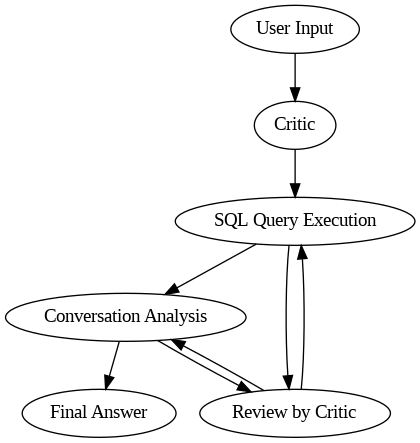

In [ ]:
#@title Flujo de Multiagentes

# Clase que representa el grafo de estados del agente
class StateGraph:
    def __init__(self):
        self.nodes = []
        self.edges = []

    def add_state(self, state_name: str):
        if state_name not in self.nodes:
            self.nodes.append(state_name)

    def add_transition(self, from_state: str, to_state: str):
        self.edges.append((from_state, to_state))

# Función para visualizar el flujo de trabajo
def visualize_workflow(graph: StateGraph):
    dot = Digraph(comment='Workflow Graph')
    dot.attr(rankdir='TB', size='8,8')

    # Añadir nodos
    for node in graph.nodes:
        dot.node(node, node)

    # Añadir aristas
    for edge in graph.edges:
        dot.edge(edge[0], edge[1])

    # Generar y mostrar la imagen
    dot.render('/tmp/workflow_graph', format='png', cleanup=True)
    display(Image('/tmp/workflow_graph.png'))

# Definir el flujo de trabajo usando la clase StateGraph
workflow = StateGraph()

# Estados
workflow.add_state("User Input")  # Entrada del usuario
workflow.add_state("Critic")  # Agente crítico que mejora la pregunta
workflow.add_state("SQL Query Execution")  # Ejecución de la consulta SQL en la base de datos
workflow.add_state("Conversation Analysis")  # Análisis de las conversaciones encontradas
workflow.add_state("Final Answer")  # Respuesta final entregada al usuario
workflow.add_state("Review by Critic")  # Revisión adicional por el agente crítico para ajustes

# Transiciones principales
workflow.add_transition("User Input", "Critic")  # Del usuario al agente crítico
workflow.add_transition("Critic", "SQL Query Execution")  # Crítico envía la consulta mejorada para ejecución SQL
workflow.add_transition("SQL Query Execution", "Conversation Analysis")  # Análisis tras obtener datos de SQL
workflow.add_transition("Conversation Analysis", "Final Answer")  # Generar la respuesta final basada en el análisis

# Agregar ciclos de retorno para retroalimentación
workflow.add_transition("SQL Query Execution", "Review by Critic")  # La ejecución SQL puede necesitar una revisión adicional
workflow.add_transition("Conversation Analysis", "Review by Critic")  # El análisis también puede necesitar revisión
workflow.add_transition("Review by Critic", "SQL Query Execution")  # Revisiones que resultan en volver a la ejecución SQL
workflow.add_transition("Review by Critic", "Conversation Analysis")  # Revisiones que resultan en análisis adicional

# Visualizar el flujo de trabajo actualizado
visualize_workflow(workflow)

**Entrada del Usuario:** El usuario hace una pregunta.

**Mejora de la Pregunta:** Un agente crítico revisa y mejora la pregunta para hacerla más clara y precisa.

**Consulta en la Base de Datos:** El sistema busca en la base de datos las conversaciones relacionadas con la pregunta mejorada.

**Análisis de Resultados:** Se analizan los resultados para identificar patrones y obtener información útil.

**Revisión Adicional:** Si los resultados no son lo suficientemente claros, el agente crítico vuelve a revisar la consulta y el análisis.

**Respuesta Final:** Finalmente, se proporciona una respuesta clara y detallada al usuario.

In [ ]:
max_iterations=20  # Establece el número máximo de iteraciones

In [ ]:
#@title Chat interactivo

# Configuración de la base de datos
table_name = "conversaciones"
column_descriptions = {
    "id": "Identificador único para cada entrada de conversación",
    "nombre": "El nombre o título del archivo de conversación",
    "contenido": "El contenido completo de la conversación en texto",
    "analisis_sentimiento": "Análisis de sentimiento de la conversación (por ejemplo, positivo, negativo, neutral)",
    "analisis_emocion": "Análisis de emociones de la conversación (por ejemplo, felicidad, tristeza, ira)",
    "analisis_entidades": "Entidades identificadas en la conversación (por ejemplo, personas, lugares, organizaciones)",
    "resumen": "Resumen de la conversación que proporciona una visión general concisa del contenido"
}

# Funciones de utilidad
def run_sqlite_query(query: str) -> str:
    conn = sqlite3.connect('conversaciones.db')
    cursor = conn.cursor()
    try:
        print(f"Ejecutando consulta SQL: {query}")
        cursor.execute(query)
        results = cursor.fetchall()
        conn.close()
        print(f"Resultados de la consulta: {results}")
        return json.dumps(results, ensure_ascii=False)
    except Exception as e:
        conn.close()
        print(f"Error al ejecutar la consulta SQL: {e}")
        return json.dumps({"error": str(e)}, ensure_ascii=False)

def get_db_structure_and_context() -> str:
    return f"Tabla: {table_name}\n" + "\n".join([f"{k}: {v}" for k, v in column_descriptions.items()])

def critic_agent(query: str) -> str:
    critic_prompt = f"""
Eres un crítico experto en análisis de datos y formulación de preguntas.
Tu tarea es analizar la siguiente pregunta y sugerir mejoras para hacerla más precisa,
relevante y fácil de responder utilizando una base de datos de conversaciones.

Pregunta original: "{query}"

Proporciona una respuesta en formato JSON con las siguientes claves:
- "analysis": Tu análisis crítico de la pregunta.
- "suggestions": Sugerencias para mejorar la pregunta.
- "reformulated_question": Una versión reformulada de la pregunta que sea más específica y fácil de responder.

Ejemplo de respuesta:
{{
  "analysis": "La pregunta es muy general y podría ser más específica.",
  "suggestions": "Especificar qué tipo de información sobre Jesús se busca.",
  "reformulated_question": "¿Qué conversaciones mencionan a Jesús en un contexto positivo?"
}}
"""
    response = custom_mistral(critic_prompt)
    return response

def analyze_conversations(query: str, conversations_json: str) -> str:
    conversations = json.loads(conversations_json)
    analysis_prompt = f"""
Analiza las siguientes conversaciones en relación con la consulta:

Consulta: "{query}"

Conversaciones:
{json.dumps(conversations, indent=2, ensure_ascii=False)}

Proporciona un análisis conciso que incluya:
1. Relevancia de las conversaciones a la consulta.
2. Patrones o temas recurrentes.
3. Sugerencias para explorar más a fondo.

Escribe tu respuesta en texto plano.
"""
    return custom_mistral(analysis_prompt)

# Herramientas
tools = [
    Tool(
        name="SQLite Query",
        func=run_sqlite_query,
        description="Ejecuta una consulta SQL en la base de datos de conversaciones."
    ),
    Tool(
        name="Critic",
        func=critic_agent,
        description="Analiza y mejora la pregunta del usuario."
    ),
    Tool(
        name="Conversation Analyzer",
        func=analyze_conversations,
        description="Analiza las conversaciones en relación con la consulta del usuario."
    )
]

# Prompts
template = """
Eres un asistente experto en análisis de datos y SQL que ayuda a consultar una base de datos de conversaciones.
Tu tarea es interpretar las preguntas del usuario, formular las consultas SQL apropiadas y proporcionar respuestas claras y concisas.

Tienes acceso a las siguientes herramientas:

{tools}

Estructura y contexto de la base de datos:
{db_structure_and_context}

Ejemplos de cómo convertir preguntas en consultas SQL:

- Pregunta: "¿Qué conversaciones mencionan a Jesús?"
  Consulta SQL: SELECT * FROM conversaciones WHERE contenido LIKE '%Jesús%';

- Pregunta: "¿Cuántas conversaciones tienen un sentimiento positivo?"
  Consulta SQL: SELECT COUNT(*) FROM conversaciones WHERE analisis_sentimiento = 'positivo';

Esta es la solicitud del usuario: "{input}"

Sigue estos pasos:

1. Usa la herramienta "Critic" **una sola vez** para analizar y mejorar la pregunta del usuario. Debes devolver **solo** un objeto JSON válido en español, sin texto adicional.

2. Utiliza la pregunta reformulada para formular la consulta SQL apropiada y usa la herramienta "SQLite Query" para ejecutarla. De nuevo, devuelve solo un objeto JSON válido.

3. Si es necesario, usa la herramienta "Conversation Analyzer" para un análisis más profundo.

4. Proporciona una respuesta final basada en toda la información recopilada. Devuelve solo un objeto JSON válido.

**Importante:** En cada paso, tu salida debe ser **únicamente** un objeto JSON válido, sin texto adicional antes o después, y en español.

Ejemplo de respuesta:

{{
  "thought": "Necesito mejorar la pregunta del usuario",
  "action": "Critic",
  "action_input": "¿Cuántas conversaciones tienen un sentimiento positivo?"
}}
STOP

Si tienes la respuesta final, usa este formato:

{{
  "thought": "He encontrado la respuesta",
  "action": "Final Answer",
  "action_input": "La respuesta a tu pregunta es..."
}}
STOP

Estos fueron los pasos previos dados para resolver esta consulta y la información que ya recopilaste:
{agent_scratchpad}
"""

class CustomPromptTemplate(StringPromptTemplate):
    template: str
    tools: List[Tool]

    def format(self, **kwargs) -> str:
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += f"{action.log}\nObservación: {observation}\n"
        kwargs["agent_scratchpad"] = thoughts
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        kwargs["db_structure_and_context"] = get_db_structure_and_context()
        return self.template.format(**kwargs)

prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    input_variables=["input", "intermediate_steps"]
)

# Clase para procesar la salida del agente
class CustomOutputParser(AgentOutputParser):
    def parse(self, llm_output: str):
        try:
            json_pattern = re.compile(r'\{.*?\}', re.DOTALL)
            match = json_pattern.search(llm_output)
            if match:
                json_str = match.group()
                response = json.loads(json_str)
                action = response.get("action")
                action_input = response.get("action_input")
                if action == "Final Answer":
                    return AgentFinish(
                        return_values={"output": action_input},
                        log=llm_output,
                    )
                else:
                    return AgentAction(tool=action, tool_input=action_input, log=llm_output)
            else:
                raise ValueError("No se encontró un objeto JSON en la salida del agente.")
        except json.JSONDecodeError as e:
            return AgentFinish(
                return_values={"output": f"Error al parsear la respuesta del agente: {e}\nSalida completa del agente: {llm_output}"},
                log=llm_output,
            )
        except Exception as e:
            return AgentFinish(
                return_values={"output": f"Error al parsear la respuesta del agente: {e}\nSalida completa del agente: {llm_output}"},
                log=llm_output,
            )

# Crear el agente
llm_chain = LLMChain(llm=custom_mistral, prompt=prompt)
tool_names = [tool.name for tool in tools]
agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=CustomOutputParser(),
    stop=["STOP"],
    allowed_tools=tool_names + ["Final Answer"]
)

# Crear el ejecutor del agente con memoria
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True),
    #max_iterations=20  # Establece el número máximo de iteraciones
)

# Función para ejecutar consultas
def run_query(query: str) -> str:
    try:
        result = agent_executor.run(query)
        return result
    except Exception as e:
        return f"Error: {str(e)}"

# Función para iniciar el chat interactivo
def interactive_chat():
    print("Bienvenido al chat interactivo. Escribe 'salir' para terminar la conversación.")
    while True:
        user_input = input("Usuario: ")
        if user_input.lower() in ["salir", "exit", "quit"]:
            print("Chat terminado.")
            break
        response = run_query(user_input)
        print(f"Asistente: {response}")

# Ejecutar el chat interactivo
if __name__ == "__main__":
    interactive_chat()


A veces pasan cosas... Hasta aquí habrás entendido que necesitas modificar la instancia para que tenga GPU.

In [ ]:
# Consultar recursos
!nvidia-smi

Fri Oct  4 18:15:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   42C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Liberar memoria
torch.cuda.empty_cache()

In [ ]:
# Cerrar entorno de ejecucion para reiniciarlo
exit()